# Basic usage with Backgrounds and Systematics

Create an instance of PyFBU

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import fbu
import uproot
import utils

np.random.seed(2018) # set the seed so that results are reproducible

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
myfbu = fbu.PyFBU()

Supply the input distribution to be unfolded as a 1-dimensional list for N bins, with each entry corresponding to the bin content.
Supply the response matrix where each row corresponds to a truth level bin.
The normalization of each row must be the acceptance efficiency of the corresponding bin (e.g. the normalization is 1 for resolution only unfolding).

In [3]:
f = uproot.open("../data/example.root")
data = f['data'].numpy
response = f['resmat'].numpy
bckg1 = f['bckg1'].numpy
bckg2 = f['bckg2'].numpy

# store backgrounds in dictionary
backgrounds = {'bckg1':bckg1[0].tolist(),
               'bckg2':bckg2[0].tolist()} # bin content for each background
backgrounds_systs = {'bckg1':0.5,     # 50% normalization uncertainty
                     'bckg2':0.04}    #  4% normalization uncertainty

# data     = (array([100., 150., 160., 110.]),    # bin content
#             array([0., 1., 2., 3., 4.]))        # bin edges
# response = (array([[0.08, 0.06, 0.03, 0.02],    # first truth bin
#                    [0.01, 0.04, 0.07, 0.1 ]]),  # second truth bin
#            (array([0., 1., 2., 3., 4.]),        # x bin edges
#             array([0., 1., 2.])))               # y bin edges
# data[0]/response[0] >> bin content
# data[1]/response[1] >> bin edges

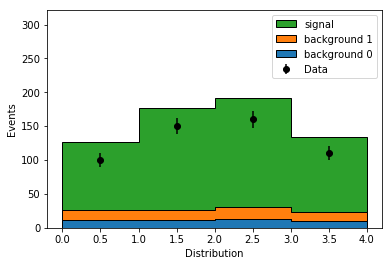

In [4]:
utils.plotYields(data[0].tolist(),
                 signal=data[0].tolist(),
                 backgrounds=[backgrounds[i] for i in backgrounds.keys()],
                 bins=data[1].tolist())

Define the boundaries of the hyperbox to be sampled for each bin.
One or more backgrounds, with the corresponding normalization uncertainties (gaussian prior), can be taken into account in the unfolding procedure.

In [5]:
myfbu.data     = data[0].tolist()
myfbu.response = response[0].tolist()
myfbu.background     = backgrounds
myfbu.backgroundsyst = backgrounds_systs

myfbu.lower = [0,0]         # lower bound on hyperbox
myfbu.upper = [3000,3000]   # upper bound on hyperbox
myfbu.nMCMC = 20000         # number of samplings
myfbu.monitoring = False    # diagnostics

Systematic uncertainties affecting signal and background can be taken into account as well with their per-bin relative magnitudes. The prior is gaussian. Each systematic needs to be provided for each background listed at the previous step. 

In [6]:
myfbu.objsyst = {
    'signal':{
            'syst1':[0.,0.03,0.02,0.01],
            'syst2':[0.,0.01,0.00,0.01]},
    'background':{
            'syst1':{'bckg1':[0.,0.,0.,0.],
                     'bckg2':[0.1,0.1,0.1,0.1]},
            'syst2':{'bckg1':[0.,0.01,0.01,0.],
                     'bckg2':[0.,0.,0.,0.]}
    }
}

Each systematic is treated as fully correlated across signal and the various backgrounds.

In [7]:
myfbu.run()

Assigned Metropolis to truth0
Assigned Metropolis to truth1
Assigned NUTS to gaus_bckg1_lowerbound__
Assigned NUTS to gaus_bckg2_lowerbound__
Assigned NUTS to gaus_syst2
Assigned NUTS to gaus_syst1
/home/dmarley/unfolding-hats/venv-fbu/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████▉| 20981/21000 [01:40<00:00, 209.56it/s]/home/dmarley/unfolding-hats/venv-fbu/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 15 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 21000/21000 [01:40<00:00, 209.54it/s]


Retrieve the N-dimensional posterior distribution in the form of a list of N arrays.

In [8]:
trace = myfbu.trace
print "> Trace = ",trace 
print "> Size of trace     = ",len(trace)
print "> Entries per trace = ",len(trace[0])

> Trace =  [array([ 888,  888,  828, ..., 1311, 1311, 1311]), array([ 883,  814, 1118, ...,  935,  977,  683])]
> Size of trace     =  2
> Entries per trace =  20000


Each array corresponds to the projection of the posterior distribution for a given bin.

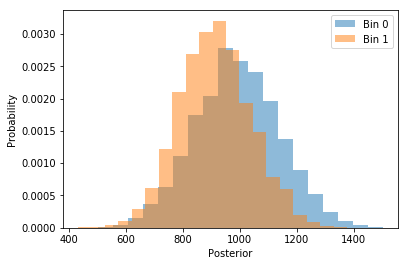

In [9]:
utils.plotPosteriors(trace)

For each unfolded bin, we can extract the mean and RMS.

In [10]:
utils.printPosteriors(trace)

 > Bin 0: 991.08 ± 147.68
 > Bin 1: 913.16 ± 125.44


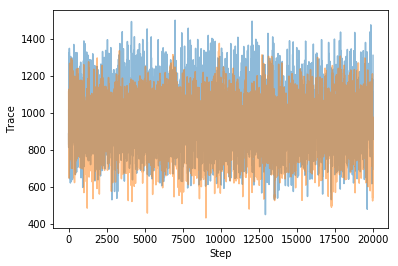

In [11]:
utils.plotTrace(trace)

# Nuisance parameters

The posterior probability for the nuisance parameters is stored in a dictionary of arrays. The correlation among nuisance parameters and with the estimates for the unfolded distribution is preserved in the array ordering.

In [12]:
listOfNuisances = ['syst1','syst2','bckg1','bckg2']
nuisances = [myfbu.nuisancestrace[nu] for nu in listOfNuisances]

Text(0.5,0,'BCKG1')

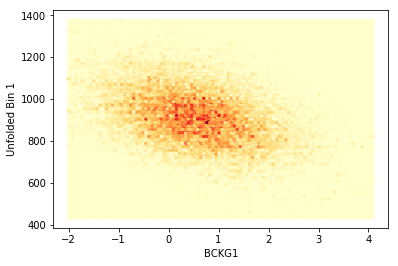

In [13]:
unfolded_bin1 = trace[1]
bckg1 = myfbu.nuisancestrace['bckg1']
plt.hexbin(bckg1,unfolded_bin1,cmap=plt.cm.YlOrRd)
plt.ylabel("Unfolded Bin 1")
plt.xlabel("BCKG1")

## Correlation Matrix
With the posterior information, it is also possible to plot the correlation matrix between the different systematic uncertainties.

[[ 1.         -0.01048435 -0.0354028   0.00279488]
 [-0.01048435  1.          0.05094207  0.00347916]
 [-0.0354028   0.05094207  1.          0.01184486]
 [ 0.00279488  0.00347916  0.01184486  1.        ]]


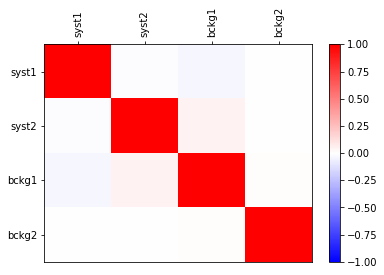

In [14]:
corrinput  = np.array(nuisances)
corrmatrix = np.corrcoef(corrinput)
corrmap    = plt.pcolor(corrmatrix,cmap=plt.cm.bwr,vmin=-1,vmax=1)

plt.xticks(np.arange(corrmatrix.shape[0])+0.5)
plt.yticks(np.arange(corrmatrix.shape[1])+0.5)
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

plt.gca().set_xticklabels(listOfNuisances,rotation=90)
plt.gca().set_yticklabels(listOfNuisances)

cb = plt.colorbar(corrmap)

print corrmatrix

## Prior vs Posterior
Let's compare the prior and posterior distributions for our systematic uncertainties.

In [15]:
means = {} # keep track of posterior means
stds  = {} # keep track of posterior std-devs

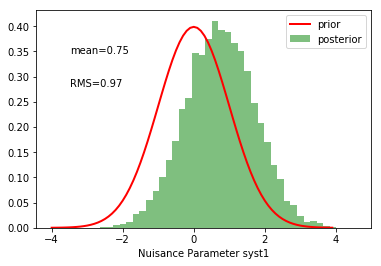

In [16]:
# syst1
name  = 'syst1'
mm,ss = utils.nuisancePriorPosterior(myfbu.nuisancestrace[name],name)
means[name] = mm
stds[name]  = ss

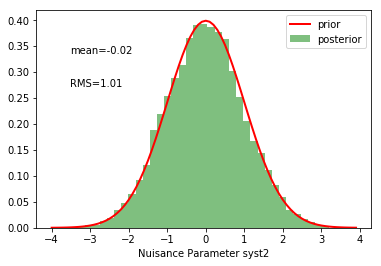

In [17]:
# syst2
name = 'syst2'
mm,ss = utils.nuisancePriorPosterior(myfbu.nuisancestrace[name],name)
means[name] = mm
stds[name]  = ss

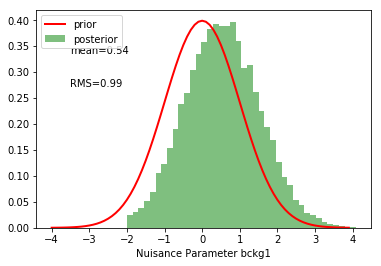

In [18]:
# bckg1
name = 'bckg1'
mm,ss = utils.nuisancePriorPosterior(myfbu.nuisancestrace[name],name)
means[name] = mm
stds[name]  = ss

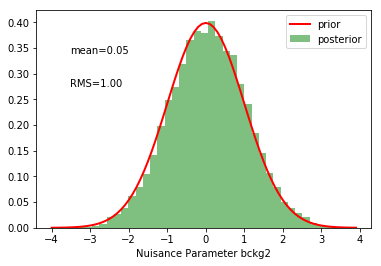

In [19]:
# bckg2
name = 'bckg2'
mm,ss = utils.nuisancePriorPosterior(myfbu.nuisancestrace[name],name)
means[name] = mm
stds[name]  = ss

## Pulls
Now we can summarize this information in a single plot that captures the pulls and constraints for each systematic uncertainty.
The prior for each systematic uncertainty is a Gaussian centered on 0 with width 1.

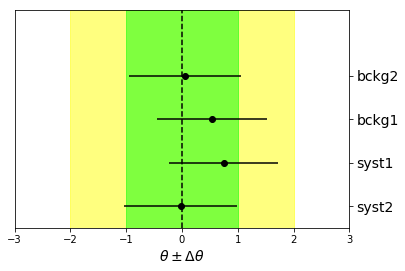

In [20]:
utils.plotPulls(means,stds)